In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import wavelet_denoiser

## Data

In [3]:
data = pd.read_excel('data/financial-time-series.xlsx', sheet_name=None) 

In [4]:
for key, val in data.items():
    print(key)
    print(val.info())
    print()

HangSeng Index Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 21 columns):
Ntime              2037 non-null int64
Time               2037 non-null int64
Closing Price      2037 non-null float64
Open Price         2037 non-null float64
High price         2037 non-null float64
Low Price          2037 non-null float64
Volume             2037 non-null float64
MACD               2037 non-null float64
CCI                2037 non-null float64
ATR                2037 non-null float64
BOLL_MID           2037 non-null float64
EMA20              2037 non-null float64
MA10               2037 non-null float64
MTM6               2037 non-null float64
MA5                2037 non-null float64
MTM12              2037 non-null float64
ROC                2037 non-null float64
SMI                2037 non-null float64
WVAD               2037 non-null float64
US Dollar Index    2037 non-null float64
HIBOR              2037 non-null float64
dtypes: float64(

In [5]:
tmp = {}

for key, val in data.items():
    key = key.lower().replace(' ', '_')
    tmp[key] = val
    
data = tmp
del tmp

In [6]:
list(data.keys())

['hangseng_index_data',
 'hangseng_index_future_data',
 's&p500_index_data',
 's&p500_index_future_data',
 'csi300_index_data',
 'csi300_index_future_data',
 'djia_index_data',
 'djia_index_future_data',
 'nikkei_225_index_data',
 'nikkei_225_index_future_data',
 'nifty_50_index_data',
 'nifty_50_index_future_data']

In [7]:
for key in data:
    new_columns = [col.lower().replace(' ', '_') for col in data[key].columns]
    data[key].columns = new_columns
    
columns = set()

for key, val in data.items():
    columns.update(val.columns)
    
columns

{'atr',
 'boll',
 'boll_mid',
 'cci',
 'close',
 'close_price',
 'closing_price',
 'date',
 'ema20',
 'federal_fund_rate',
 'hibor',
 'high_price',
 'interbank_offered_rate',
 'low_price',
 'ma10',
 'ma5',
 'macd',
 'matlab_time',
 'mtm12',
 'mtm6',
 'ntime',
 'num_time',
 'open_price',
 'roc',
 'shibor',
 'smi',
 'time',
 'us_dollar_index',
 'volume',
 'wvad'}

In [8]:
data['s&p500_index_data'].describe().transpose()[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
ntime,2079.0,2.012185e+07,2.407961e+04,2.008070e+07,2.016093e+07
time,2079.0,7.350966e+05,8.712300e+02,7.335900e+05,7.366030e+05
close_price,2079.0,1.510099e+03,4.144007e+02,6.765300e+02,2.190150e+03
open_price,2079.0,1.509691e+03,4.142737e+02,6.792800e+02,2.187810e+03
high_price,2079.0,1.518776e+03,4.136775e+02,6.952700e+02,2.193810e+03
low_price,2079.0,1.499889e+03,4.148676e+02,6.667900e+02,2.186800e+03
volume,2079.0,4.134759e+05,1.230301e+05,5.362000e+04,1.145623e+06
macd,2079.0,2.696996e+00,1.597647e+01,-7.719827e+01,3.213155e+01
cci,2079.0,1.996444e+01,1.051766e+02,-3.281306e+02,2.730617e+02
atr,2079.0,1.961153e+01,1.276455e+01,3.680000e+00,1.077100e+02


In [9]:
data['s&p500_index_data']['date'] = pd.to_datetime(
    data['s&p500_index_data']['time'] - data['s&p500_index_data']['time'].min(), 
    unit='D', 
    origin='2008-07-01'
)

In [40]:
print(
    "Start date:", 
    data['s&p500_index_data']['date'].min()
)

print(
    "End date:",
    data['s&p500_index_data']['date'].max()
)

Start date: 2008-07-01 00:00:00
End date: 2016-09-30 00:00:00


In [26]:
original = data['s&p500_index_data']['close_price']
denoised = wavelet_denoiser.wavelet_transform(data['s&p500_index_data']['close_price'])

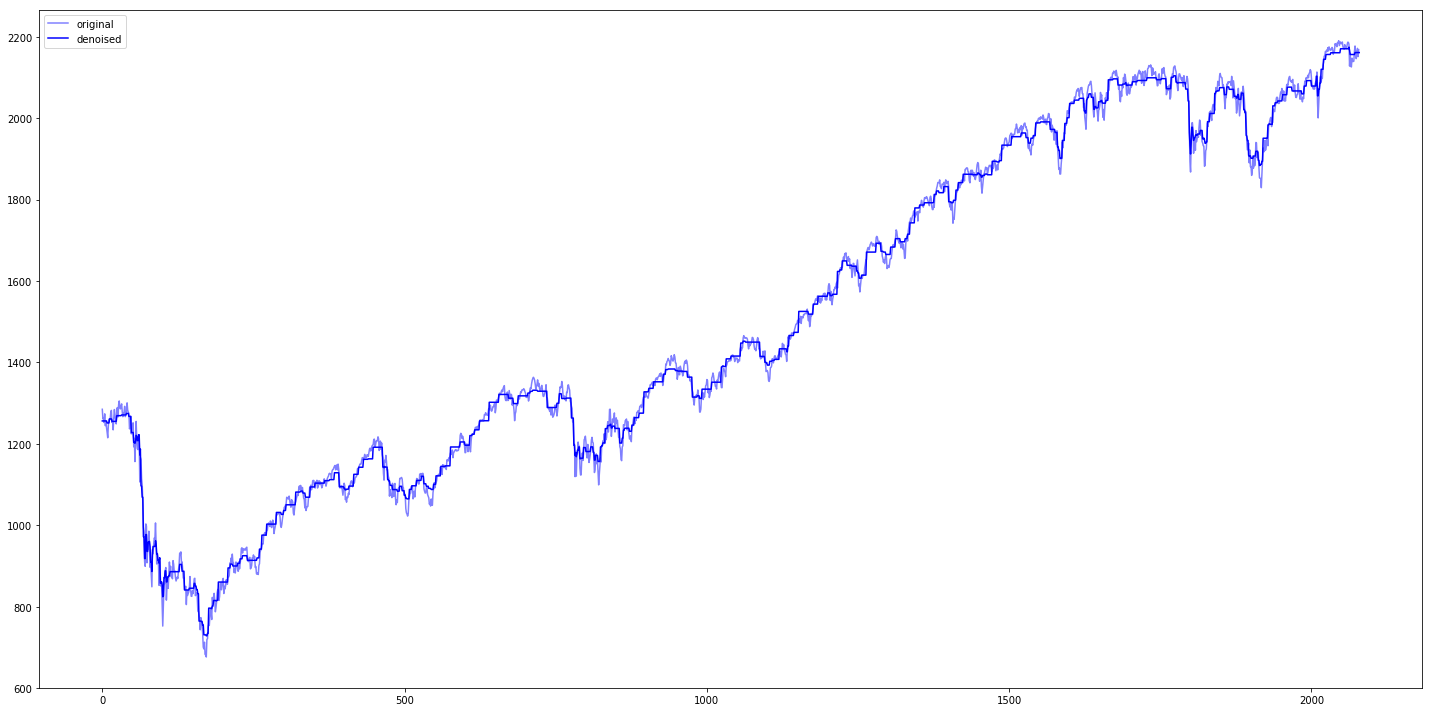

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(original, color='b', alpha=0.5, label='original')
ax.plot(denoised, color='b', label='denoised')

plt.legend(loc='best')
plt.tight_layout()
plt.show();